In [1]:
import pandas as pd
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
import matplotlib
import numpy as np
matplotlib.rcParams.update({'font.size': 14})

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

## Paths

In [2]:
holdout_path = '/Users/josephking/Documents/sponsored_projects/MERGEN/output/MakeModelClassifier/2021-11-30-22h08/logs'
therm_path = '/Users/josephking/Documents/sponsored_projects/MERGEN/scripts/output/2021-12-01-11h56_med_therm/logs'
output_path = '/Users/josephking/Desktop/export'

## CMC Curve as Line

In [3]:
def read_convert_cmc(path):
    df = pd.read_csv(os.path.join(path, 'predicted_classes.csv'))
    true = df['true_label'].copy()
    del df['true_label']
    
    df = df.apply(lambda x: true == x)
    df = df.mean().cumsum().reset_index().rename(columns={0: 'Accuracy'})
    df['Accuracy'] = df['Accuracy'] * 100
    del df['index']
    df = df.reset_index()
    df.index = df['index'] + 1
    del df['index']
    return df

In [4]:
cmc_holdout = read_convert_cmc(holdout_path)
cmc_therm = read_convert_cmc(therm_path)

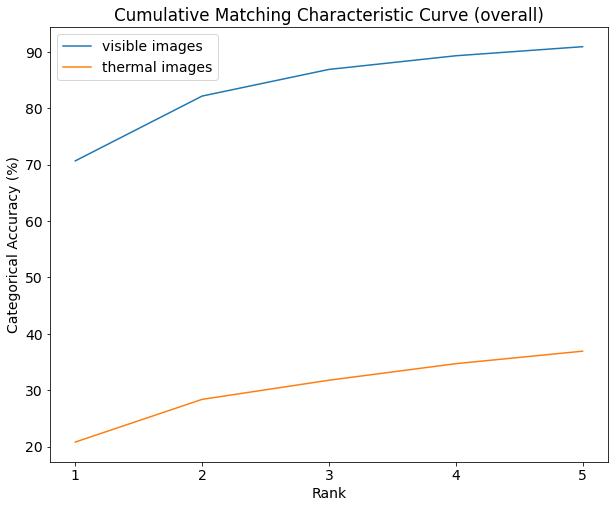

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
fig.set_facecolor('white')
ax.plot(cmc_holdout.iloc[:5], label='visible images')
ax.plot(cmc_therm.iloc[:5], label='thermal images')
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Rank')
plt.ylabel('Categorical Accuracy (%)')
plt.title('Cumulative Matching Characteristic Curve (overall)')
plt.savefig(os.path.join(output_path, 'cmc_5.png'), dpi=200)
plt.show()

## Plot ROC Curves function

In [6]:
def plot_micro_macro(fpr, tpr, roc_auc, name='Holdout'):
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.set_facecolor('white')

    # Micro
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average (area = {0:0.3f})".format(roc_auc["micro"]),
        color="deeppink",
        linewidth=2,
    )

    # Macro
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average (area = {0:0.3f})".format(roc_auc["macro"]),
        color="navy",
        linewidth=2,
    )

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.title(f'Receiver Operating Characteristic (ROC) Curve: {name} Set')
    plt.savefig(os.path.join(output_path, f'ROC_{name}.png'), dpi=200)
    plt.show()

## ROC Curve function

In [7]:
def calculate_roc(path):
    
    # Credit: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    df = pd.read_csv(os.path.join(path, 'predictions.csv'))
    classes = list(df.iloc[:, :-1].columns)  # class names
    
    # labels
    y = label_binarize(np.array(df['true_label']), classes=classes)
    
    # predictions
    y_pred = np.array(df.iloc[:, :-1])
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_pred[:, i], pos_label=1)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'], _ = roc_curve(y.ravel(), y_pred.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
    
    # Aggregate false positives
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

    # Interpolate ROC curves
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Average and compute AUC
    mean_tpr /= len(classes)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return fpr, tpr, roc_auc

## Using holdout set from Google scraped images

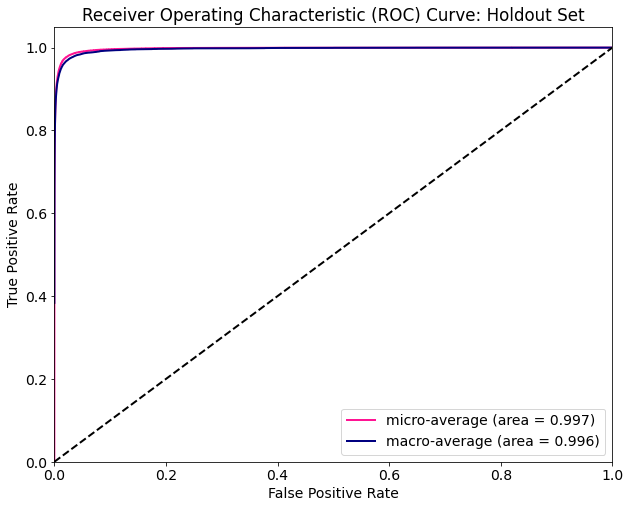

In [8]:
fpr_holdout, tpr_holdout, roc_auc_holdout = calculate_roc(holdout_path)
plot_micro_macro(fpr_holdout, tpr_holdout, roc_auc_holdout)

## Using holdout set, reducing to three classes

Classes have widely varying F1 statistics

In [9]:
df = pd.read_csv(os.path.join(holdout_path, 'predictions.csv'))

cols = ['Ford E-Series', 'Honda Civic', 'INFINITI Q']

df_r = df.loc[df['true_label'].isin(cols)].copy().reset_index(drop=True)

# labels
y = label_binarize(np.array(df_r['true_label']), classes=cols)


y_pred = df_r[['Ford E-Series', 'Honda Civic', 'INFINITI Q']].copy()
s = y_pred.sum(axis=1)
for col in y_pred.columns:
    y_pred[col] = y_pred[col] / s

y_pred = np.array(y_pred)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(cols)):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_pred[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

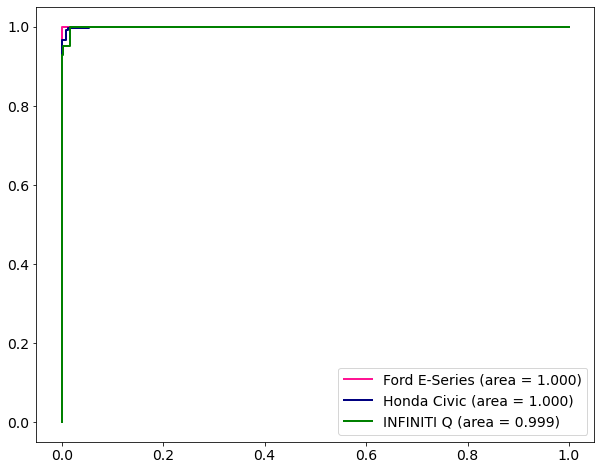

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
fig.set_facecolor('white')

# Ford F-Series
class_one = 0
plt.plot(
        fpr[class_one],
        tpr[class_one],
        label="Ford E-Series (area = {0:0.3f})".format(roc_auc[class_one]),
        color="deeppink",
        linewidth=2,
)

# Honda Civic
class_two = 1
plt.plot(
        fpr[class_two],
        tpr[class_two],
        label="Honda Civic (area = {0:0.3f})".format(roc_auc[class_two]),
        color="navy",
        linewidth=2,
)

# INFINITI Q
class_three = 2
plt.plot(
        fpr[class_three],
        tpr[class_three],
        label="INFINITI Q (area = {0:0.3f})".format(roc_auc[class_three]),
        color="green",
        linewidth=2,
)

plt.legend()
plt.savefig(os.path.join(output_path, 'holdout_three_classes.png'), dpi=200)
plt.show()

## Make-Model classifier trained with just 3 classes

Classes are: 'Ford E-Series', 'Honda Civic', 'INFINITI Q'
I trained this 3 epochs on my Booz laptop. Val categorical accuracy was 90.74%.

In [11]:
new_path = '/Users/josephking/Documents/sponsored_projects/MERGEN/scripts/output/tests/2022-01-23-14h42/logs'
fpr, tpr, roc_auc = calculate_roc(new_path)

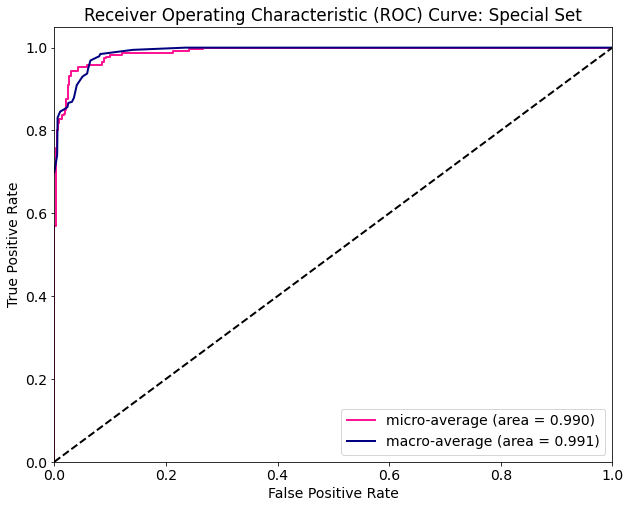

In [12]:
plot_micro_macro(fpr, tpr, roc_auc, 'Special')